***Import libraries***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading as th

***Read Data***

In [2]:
df = pd.read_csv("heart.csv")

# Data Visualization

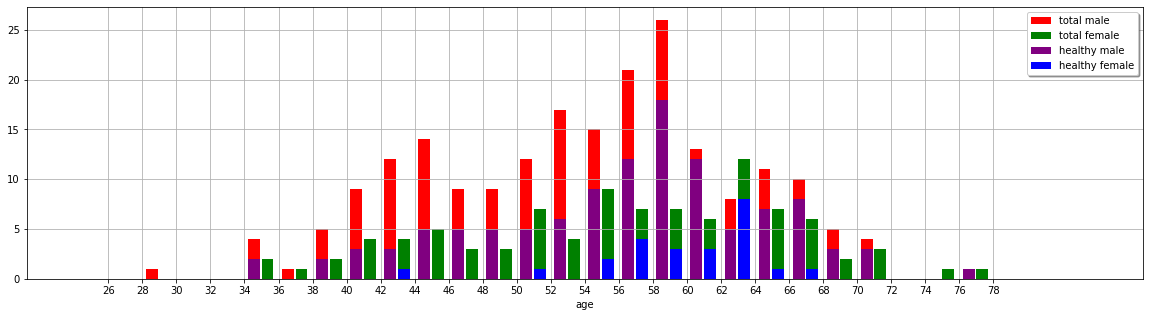

In [3]:
plt.figure(figsize = (20, 5))
 
plt.hist([df['age'][df['sex']==1], df['age'][df['sex']==0]], bins=range(24, 85, 2), color=['red', 'green'], label = ["total male", "total female"], width=0.7)
plt.hist([df['age'][(df['output'] == 0) & (df['sex']==1)], df['age'][(df['output'] == 0) & (df['sex']==0)]], bins=range(24, 85, 2), color=['purple', 'blue'], label = ["healthy male", "healthy female"], width=0.7)
plt.xticks(np.arange(26, 80, 2))
plt.xlabel("age")
plt.legend(shadow=True, fontsize=10, loc=0)
 
plt.grid(True)
plt.show()

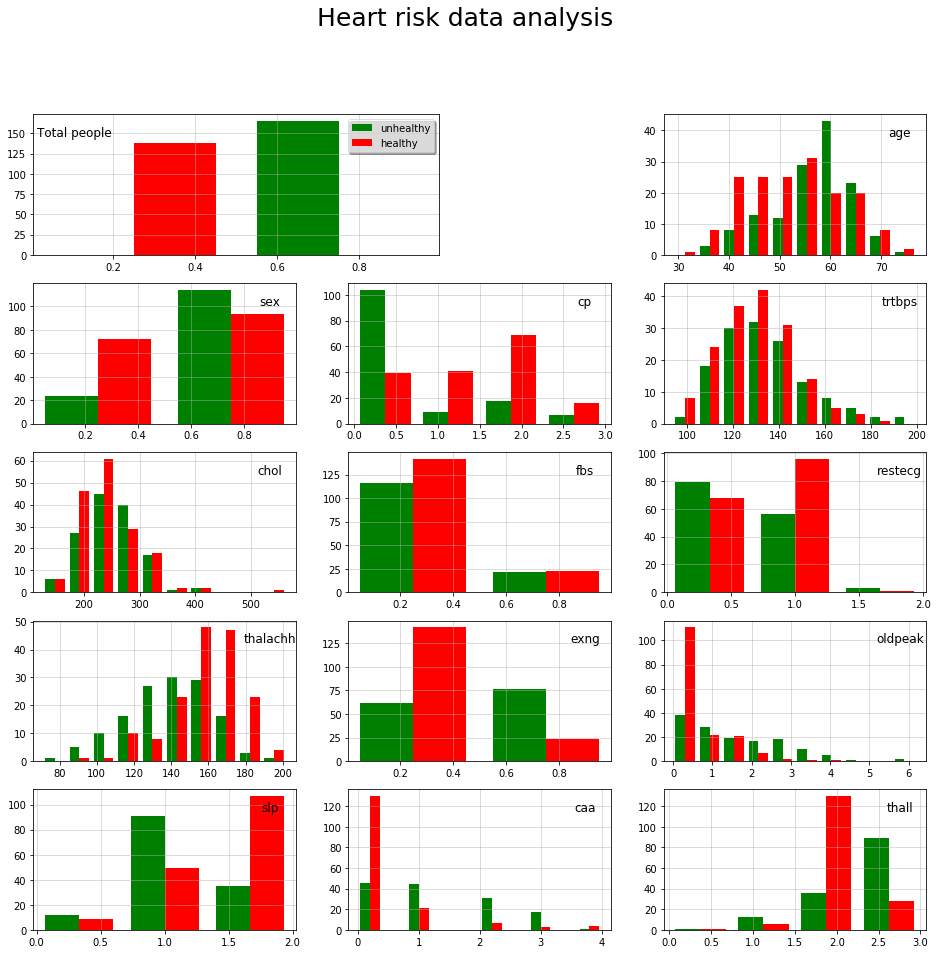

In [4]:
i = 1
plt.figure(figsize=(16, 15))
plt.suptitle("Heart risk data analysis", fontsize=25)

plt.subplot(5, 2, 1)
plt.title("Total people", x=0.1, y=0.8)
plt.hist([df['output'][df['output']==1], df['output'][df['output']==0]], bins=2, color = ['g', 'r'], label=['unhealthy', 'healthy'])
plt.legend(loc=0, framealpha=0.6, shadow=True)
plt.grid(True, alpha=0.55)

for x in df.columns[:-1]:
    plt.subplot(5, 3, i+2)
    i += 1
    plt.title(x, x=0.9, y=0.8)
    if len(list(set(df[x]))) < 5:
        bins = len(list(set(df[x])))
    else:
        bins = 10
    plt.hist([df[x][df["output"]==0], df[x][df["output"]==1]], bins=bins, color=['g', 'r'])
    plt.grid(True, alpha=0.55)
    
plt.show()

# Functions and Classes

## Helper functions

get_data_from() takes the pandas data frame and separates it in x and y for model

normalize() takes the data and returns its normalized form along with data's mean and standard deviation

In [5]:
def get_data_from(df):
    x = np.array(df.iloc[:, :-1])
    y = np.array(df.iloc[:, -1]).reshape((-1, 1))
    return x, y
 
def normalize(data, axis=0):
    mu = data.mean(axis)
    sigma = data.std(axis)
    
    data = (data-mu)/sigma
    
    return (data, mu, sigma)

## Activation and their derivative functions

Activation functions like 
1. sigmoid
2. tanh
3. relu 
4. leaky relu

and their corresponding derivative functions are defined.

In [6]:
def sigmoid(x):
    a = 1 / (1+np.e**(-x))
    return a
 
def d_sigmoid(a):
    return a*(1-a)
 
def d_tanh(a):
    return 1-a**2
 
def relu(x):
    a = x.copy()
    a[x<0] = 0
    return a
 
def d_relu(a):
    dz = np.ones_like(a)
    dz[a<0] = 0
    return dz
 
def l_relu(x):
    a = x.copy()
    a[x<0] = a[x<0]*0.01
    return a
 
def d_l_relu(a):
    dz = np.ones_like(a)
    dz[a<0] *= 0.01
    return dz

 ## Activation Class

Activation class keeps the activation and its derivative function together for the ease of use in neural network

In [7]:
class activation:
    def __init__(self, func="sigmoid", d_func=None):
        if type(func) == type("string"):
            if func.startswith(('s', 'S')):
                self.func   = sigmoid
                self.d_func = d_sigmoid
            elif func.startswith(('t', 'T')):
                self.func   = np.tanh
                self.d_func = d_tanh
            elif func.startswith(('r', 'R')):
                self.func   = relu
                self.d_func = d_relu
            elif func.startswith(('l', 'L')):
                self.func   = l_relu
                self.d_func = d_l_relu
            elif func.startswith('o'):
              self.func   = lambda z: z
              self.d_func = lambda z: 1
                
        elif d_func is None:
            print("Specify the derivative of function")

## Neural Network Class

This class has learning parameters
1. weights
2. biases
3. alpha for batch normalization
4. beta for batch normalization

and some functions
1. constructor function that forms the architecture of network using the list passed in layers that has numbers for neurons in each layer
2. <b>forward_prop() to perform forward propagation using the passed data</b>
3. <b>back_prop() to perform back propagation and update the learning paramenters</b>
4. <b>cal_cost() for calculating the cost or loss</b>

In [8]:
class neural_network:
    def __init__(self, layers, func = np.tanh):
        self.layers = layers
        n = len(layers)
        self.act = [activation(func) for i in range(n)]
        self.act[n-1] = activation('sigmoid')
 
        if self.act[0].func == np.tanh or self.act[0].func == sigmoid:
            fact = [1] + [1/(layers[i-1]**0.5) for i in range(1, n)]
        else:
            fact = [1] + [1/((layers[i-1]+layers[i])**0.5) for i in range(1, n)]
        
        self.w = [None] + [np.random.randn(layers[i], layers[i-1])*fact[i] for i in range(1, n)]    # weights
        self.b = [None] + [np.random.randn(layers[i], 1)*fact[i] for i in range(1, n)]              # biases
        
        self.dJ_dw = [None] + [np.random.randn(layers[i], layers[i-1]) for i in range(1, n)]        # Jacobian matrices of weights
        self.dJ_db = [None] + [np.random.randn(layers[i], 1) for i in range(1, n)]                  # Jacobian matrices of biases
        
        self.alpha = [np.random.random((layers[i], 1)) for i in range(n)]           # alpha for batch normalization
        self.beta  = [np.random.random((layers[i], 1)) for i in range(n)]           # beta for batch normalization
        
        self.dJ_dalpha = [np.random.random((layers[i], 1)) for i in range(n)]       # Jacobian matrices of alpha
        self.dJ_dbeta  = [np.random.random((layers[i], 1)) for i in range(n)]       # Jacobian matrices of beta
        
        self.mu    = [np.random.random((layers[i], 1)) for i in range(n)]
        self.sigma = [np.random.random((layers[i], 1)) for i in range(n)]
               
        self.z = [np.zeros((x, 1)) for x in layers]                                                  # Wx + b
        self.a = [np.zeros((x, 1)) for x in layers]                                                  # activations
        
        
    def forward_prop(self, x):
        self.a[0] = x.reshape((x.shape[0], x.shape[1], 1))
        m = self.a[0].shape[0]
 
        for i in range(1, len(self.layers)):
            self.z[i] = ((self.w[i].dot(self.a[i-1])).reshape((1, -1, m))).T       #z''
            self.z[i], self.mu[i], self.sigma[i] = normalize(self.z[i])            #z'
            self.z[i] = self.alpha[i]*self.z[i] + self.beta[i]                     #z
            
            self.a[i] = self.act[i].func(self.z[i])
 
        return self.a[-1]
    
    def back_prop(self, x, y, alpha=0.01, m_beta = 0.1, initial = False):
        m = self.a[-1].shape[0]        # number of examples
        
        dJ_dz = self.a[-1] - y.reshape((m, -1, 1))
        
        if initial:
            m_beta = 0
        
        for i in range(-1, -len(self.layers), -1):
            w = self.w[i]
            b = self.b[i]
            alp = self.alpha[i]
            bet = self.beta[i]
            
            z1 = (self.z[i]-self.beta[i]) / self.alpha[i]
 
            dz_dz1   = self.alpha[i]
            dz1_dz11 = 1/self.sigma[i]
            dz11_dw = self.a[i-1].reshape((m, 1, -1))
            
            dJ_dw = dJ_dz * (dz_dz1 * dz1_dz11 * dz11_dw)
            # dJ_db = dJ_dz           # Since beta for batch normalization can perform the same role, bias term can be omitted
            dJ_dalpha = dJ_dz * z1
            dJ_dbeta  = dJ_dz
                    
            # Adding momentum
            self.dJ_dw[i] = self.dJ_dw[i]*m_beta + dJ_dw
            # self.dJ_db[i] = self.dJ_db[i]*m_beta + dJ_db           
            self.dJ_dalpha[i] = self.dJ_dalpha[i]*m_beta + dJ_dalpha
            self.dJ_dbeta[i]  = self.dJ_dbeta[i]*m_beta + dJ_dbeta            
                            
            ######################### parameters update
            self.w[i] -= alpha * self.dJ_dw[i].sum(axis=0) / m
            # self.b[i] -= alpha * self.dJ_db[i].sum(axis=0) / m
            
            self.alpha[i] -= alpha * self.dJ_dalpha[i].sum(axis=0) / m
            self.beta[i]  -= alpha * self.dJ_dbeta[i].sum(axis=0) / m
    
            ######################### data for previous layer
            dz_da = w.T
            dJ_da = dz_da.dot(dJ_dz).reshape((1, -1, m)).T
            
            da_dz = self.act[i-1].d_func(self.a[i-1])
            dJ_dz = dJ_da * da_dz
        
    def cal_cost(self, y, h=None):
        if h is None:
            h = self.a[-1]
        
        h = h.reshape((-1, 1))
        cost = -(y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h))) / (y.shape[0])
 
        return cost

# Trying different models

 ### Loading the data

In [9]:
df = pd.read_csv(r"heart.csv")
x, y = get_data_from(df)

### Function to run the network and learn the parameters

This function takes
1. network to run
2. title for the cost vs iteration plot that it generates
3. keep_prints for keeping the prints on for number of iterations done
4. alpha0 hyperparameter for learning rate
5. beta hyperparamter for momentum in gradient descent

In [18]:
def try_net(net, title, iterations=50000, keep_prints=True, alpha0=2, beta=0.1):    
    print("thread for", title, "started")
    costs = []
    print_after = iterations//5

    for i in range(iterations):
        if keep_prints and i%print_after == 1:
            print(title, "\titeration", i, "\tcost =", costs[-1])
        h = net.forward_prop(x)
        costs.append(net.cal_cost(y)[0, 0])
            
        alpha = alpha0/(1+(i//10000))            # Decaying alpha is used
        flag = (i==0)
        net.back_prop(x, y, alpha, m_beta=beta, initial = flag)
 
    plt.figure()
    plt.plot(costs)
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.title(title)
    plt.show()
    print(costs[-1])
    
    pred = net.a[-1].reshape(-1, 1) > 0.5
    Y = y > 0.5
 
    TP = np.sum(pred & Y)
    TN = np.sum((pred == False) & (Y==False))
    FP = np.sum(pred & (Y==False))
    FN = np.sum((pred==False) & Y)
 
    prec = TP / (TP+FP)
    rec = TP / (TP + FN)
    acc = (TP+TN)/(TP+TN+FP+FN)
 
    f1_score = 2*prec*rec / (prec+rec)
    
    print("thread", title, "is done")
    print("precision = {}\nrecall = {}\nf1_score = {}".format(prec, rec, f1_score))
    results.append((title, prec, rec, f1_score, acc))
    
    return net

 ### Creating and running threads for models with different activation functions

Here models with different activation functions are tried using threading

thread for sigmoid started
thread for tanh started
thread for relu started
thread for l_relu started


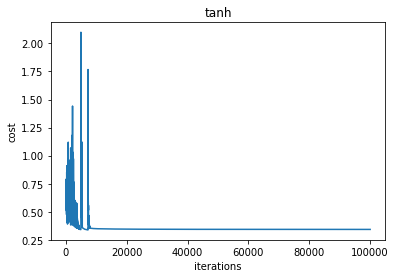

0.342284417818941
thread tanh is done
precision = 0.8296703296703297
recall = 0.9151515151515152
f1_score = 0.8703170028818444


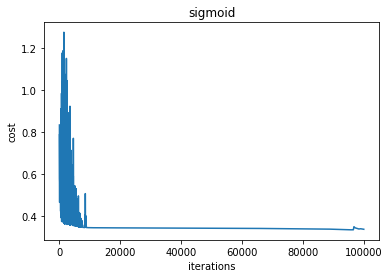

0.33800787704189195
thread sigmoid is done
precision = 0.8514285714285714
recall = 0.9030303030303031
f1_score = 0.8764705882352941


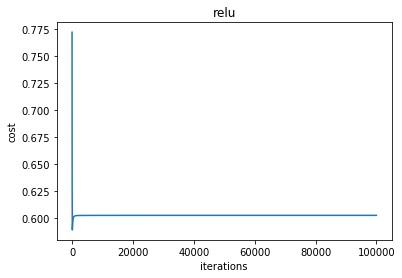

0.6025824070029143
thread relu is done
precision = 0.7426470588235294
recall = 0.6121212121212121
f1_score = 0.6710963455149502


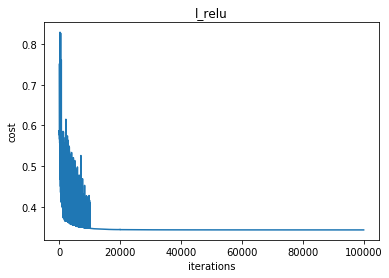

0.34350894292314266
thread l_relu is done
precision = 0.8172043010752689
recall = 0.9212121212121213
f1_score = 0.8660968660968662


In [11]:
act_funcs = ['sigmoid', 'tanh', 'relu', 'l_relu']
arch = [x.shape[1], 2, 1]
iterations = 100000
threads = []
results = []
 
# Comment below 3 lines in case you want to retrain your previous models stored in nets when you ran this cell before.
nets = []
for func in act_funcs:
    nets.append(neural_network(arch, func))
    
for i, func in enumerate(act_funcs):
    t = th.Thread(target=try_net, args=(nets[i], func, iterations, False))
    threads.append(t)
    
for t in threads:
    t.start()
    
for t in threads:
    t.join()

 ### Making and running a single neuron (logistic regression) model

thread for 1 neuron started
1 neuron 	iteration 1 	cost = 0.7595290142911031
1 neuron 	iteration 20001 	cost = 0.348999956812784
1 neuron 	iteration 40001 	cost = 0.3489121054582438
1 neuron 	iteration 60001 	cost = 0.34890635696057254
1 neuron 	iteration 80001 	cost = 0.3489051219497628


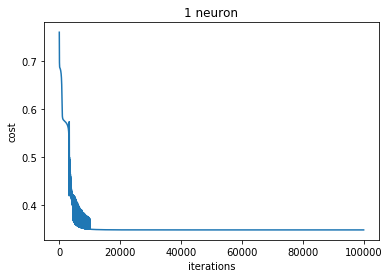

0.3489046971401753
thread 1 neuron is done
precision = 0.8260869565217391
recall = 0.9212121212121213
f1_score = 0.8710601719197708


In [37]:
try_net(neural_network([x.shape[1], 1], "sigmoid"), "1 neuron", 100000, alpha0=0.08)

## Analyzing the models

### Making a dataframe of performance metric

In [30]:
col = ['function', 'precision', 'recall', 'f1 score', 'accuracy']
result = pd.DataFrame(results, columns=col)
 
idx = result.iloc[:, 0]
ids = {}
for i, val in enumerate(idx):
    ids[val] = i
    
result.set_index("function", inplace=True)

### Plotting the performance metric data

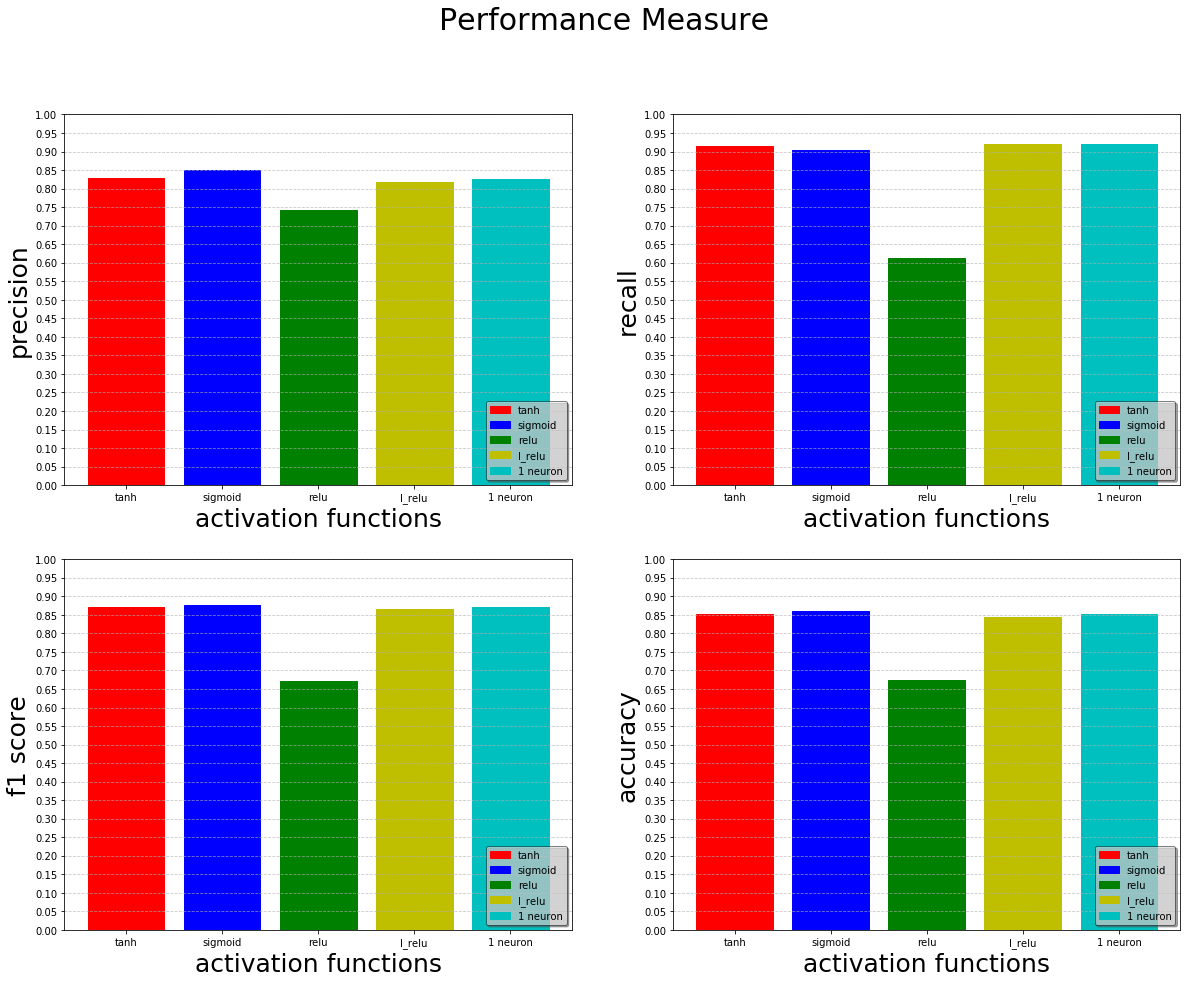

In [36]:
colors = ['r', 'b', 'g', 'y', 'c', 'm', 'k', 'pink', 'purple', 'gold', 'silver', 'violet']
plt.figure(figsize=(20, 15))
plt.suptitle("Performance Measure", fontsize=30)
for i, col in enumerate(result.columns):
    plt.subplot(2, 2, i+1)
    plt.grid(True, alpha=0.7, axis='y', ls='--')
#     plt.title(col, fontsize=25, y=0.92)
    bars = plt.bar(result.index, result[col])
    
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
        bar.set_label(result.index[i])
        
    plt.legend(loc=4, shadow=True, fontsize=10, framealpha=0.5, edgecolor='k')
    plt.xlabel('activation functions', fontsize=25)
    plt.yticks(np.arange(0, 1.01, 0.05))
    plt.ylabel(col, fontsize=25)
plt.show()